In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
import matplotlib.dates as mdates
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot, moment
import xgboost as xgb

## SOFR Averages and Index Data ##
* As an extension of the Secured Overnight Financing Rate (SOFR), the SOFR Averages are compounded averages of the SOFR over rolling 30-, 90-, and 180-calendar day periods.
* The SOFR Index measures the cumulative impact of compounding the SOFR on a unit of investment over time, with the initial value set to 1.00000000 on April 2, 2018, the first value date of the SOFR.
* The SOFR Index value reflects the effect of compounding the SOFR each business day and allows the calculation of compounded SOFR averages over custom time periods.
* Each business day, the New York Fed publishes the SOFR Averages and SOFR Index on the New York Fed's website, shortly after the SOFR is published at approximately 8:00 a.m. ET.

# Daily SOFR #

c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


<Axes: title={'center': 'Daily SOFR'}, xlabel='date'>

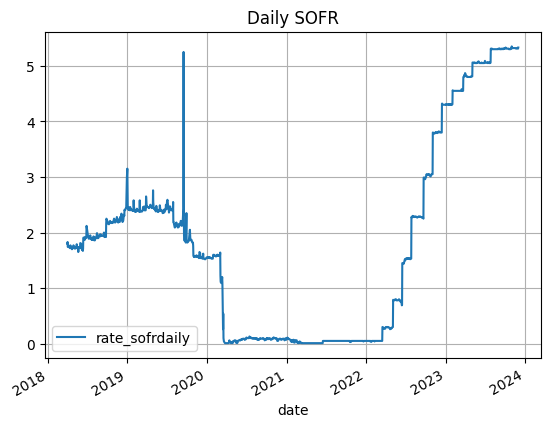

In [2]:
# this is our target?
y_SOFRDAILY = pd.read_excel(f"../data/sofrdaily.xlsx")
y_SOFRDAILY = y_SOFRDAILY.dropna(axis="columns")
y_SOFRDAILY.columns = ["date", "type", "rate_sofrdaily", "vol"]
y_SOFRDAILY["date"] = pd.to_datetime(y_SOFRDAILY["date"])
y_SOFRDAILY.set_index("date", inplace=True)
y_SOFRDAILY.drop(columns=["type", "vol"], inplace=True)
y_SOFRDAILY = y_SOFRDAILY.iloc[::-1]
y_SOFRDAILY.plot(grid=True, title="Daily SOFR")

# 30, 90, 180 D Compounded SOFR #

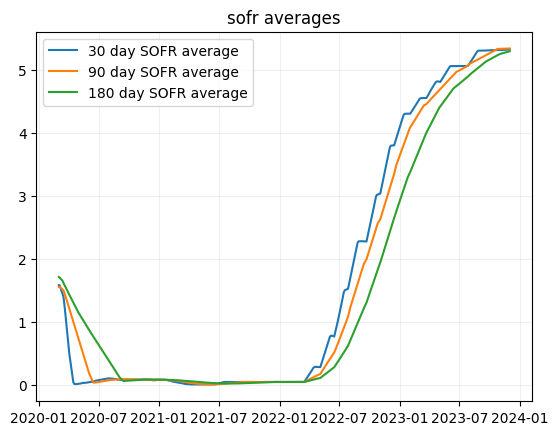

In [3]:
# this is our target?
y_SOFRAI = pd.read_excel(f"../data/sofravg.xlsx")
y_SOFRAI = y_SOFRAI.dropna(axis="columns")
y_SOFRAI.columns = ["date", "type", "30d", "90d", "180d", "idx"]
y_SOFRAI["date"] = pd.to_datetime(y_SOFRAI["date"])
y_SOFRAI = y_SOFRAI.iloc[::-1]
y_SOFRAI.set_index("date", inplace=True)
y_SOFRAI.drop(columns=["type"], inplace=True)
plt.title("sofr averages")
plt.plot(y_SOFRAI["30d"], label="30 day SOFR average")
plt.plot(y_SOFRAI["90d"], label="90 day SOFR average")
plt.plot(y_SOFRAI["180d"], label="180 day SOFR average")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

# 3 Month Term CME SOFR - problematic data, need to fix - UNUSED #

In [4]:
# this is for comparison
x_CME3MSOFR = pd.read_csv(f"../data/CME3MSOFR.csv")
x_CME3MSOFR = x_CME3MSOFR.dropna(axis="columns")
x_CME3MSOFR.drop(columns=["dd", "mm", "yyyy"], inplace=True)
x_CME3MSOFR.columns = ["date", "rate_CME3MSOFR"]
x_CME3MSOFR["date"] = pd.to_datetime(x_CME3MSOFR["date"])
# flip it so that first row
x_CME3MSOFR = x_CME3MSOFR.iloc[::-1]
x_CME3MSOFR.reset_index(inplace=True)
x_CME3MSOFR = x_CME3MSOFR.drop(columns=["index"])
x_CME3MSOFR.set_index("date", inplace=True)
print(x_CME3MSOFR.head())
# plt.figure(figsize=(15, 10))
# plt.scatter(x=x_CME3MSOFR.index, y=x_CME3MSOFR["rate_CME3MSOFR"])

            rate_CME3MSOFR
date                      
2019-01-03          2.4328
2019-01-04          2.4296
2019-01-07          2.4276
2019-01-08          2.4298
2019-01-09          2.4390


# 3 Month T-Bill rates #

In [5]:
# this is our feature
# USTbill3M
x_USTbill3M = pd.read_csv(f"../data/USTbill3M.csv")
x_USTbill3M = x_USTbill3M.dropna(axis="columns")
x_USTbill3M.columns = ["date", "rate_USTbill3M"]
x_USTbill3M["date"] = pd.to_datetime(x_USTbill3M["date"])
# no need flip, already in correct order
x_USTbill3M.set_index("date", inplace=True)
print(x_USTbill3M.head())

            rate_USTbill3M
date                      
2018-11-26          2.3775
2018-11-27          2.3771
2018-11-28          2.3704
2018-11-29          2.3616
2018-11-30          2.3654


# 1 Month T-Bill rates #

In [6]:
# this is our feature
# USTbill1M
x_USTbill1M = pd.read_csv(f"../data/USTbill1M.csv")
x_USTbill1M = x_USTbill1M.dropna(axis="columns")
x_USTbill1M.columns = ["date", "rate_USTbill1M"]
x_USTbill1M["date"] = pd.to_datetime(x_USTbill1M["date"])
# no need flip, already in correct order
x_USTbill1M.set_index("date", inplace=True)
print(x_USTbill1M.head())

            rate_USTbill1M
date                      
2023-11-22          5.3506
2023-11-21          5.3375
2023-11-20          5.3507
2023-11-17          5.3475
2023-11-16          5.3506


Text(0.5, 1.0, 'US t bill rates')

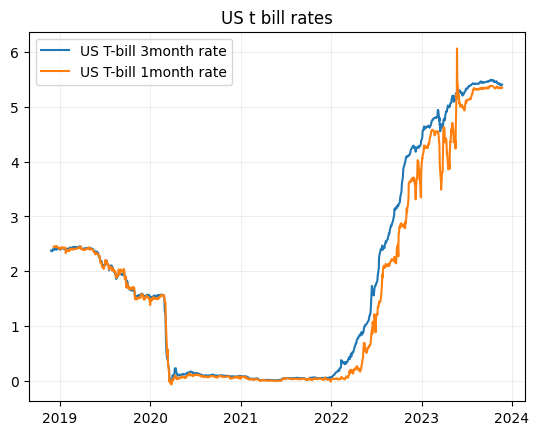

In [7]:
plt.plot(x_USTbill3M, label="US T-bill 3month rate")
plt.plot(x_USTbill1M, label="US T-bill 1month rate")
plt.grid(alpha=0.2)
plt.legend()
plt.title("US t bill rates")

# 3 Month SOFR Futures #

            price_3MSOFRFuture
date                          
2018-12-14              97.370
2018-12-17              97.405
2018-12-18              97.455
2018-12-19              97.460
2018-12-20              97.470


<Axes: title={'center': '3 month SOFR future price'}, xlabel='date'>

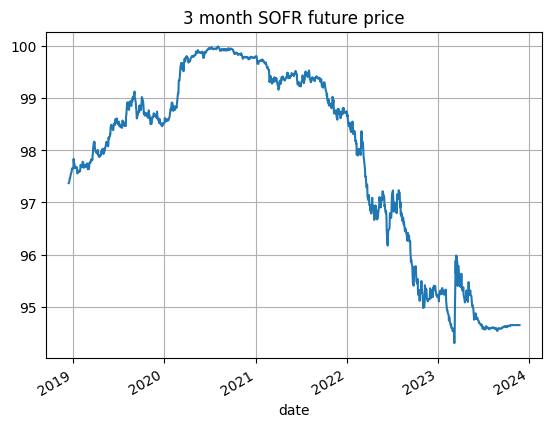

In [8]:
# this is our feature
# 3MSOFRFuture
x_3MSOFRFuture = pd.read_csv(f"../data/3MSOFRFuture.csv")
x_3MSOFRFuture = x_3MSOFRFuture.dropna(axis="columns")
x_3MSOFRFuture.drop(columns=["dd", "mm", "yyyy"], inplace=True)
x_3MSOFRFuture.columns = ["date", "price_3MSOFRFuture"]
x_3MSOFRFuture["date"] = pd.to_datetime(x_3MSOFRFuture["date"])
# flip it so that first row
x_3MSOFRFuture = x_3MSOFRFuture.iloc[::-1]
x_3MSOFRFuture.reset_index(inplace=True)
x_3MSOFRFuture = x_3MSOFRFuture.drop(columns=["index"])
x_3MSOFRFuture.set_index("date", inplace=True)
print(x_3MSOFRFuture.head())
x_3MSOFRFuture["price_3MSOFRFuture"].plot(grid=True, title="3 month SOFR future price")

## Broad General Collateral Rate Data ##
The Broad General Collateral Rate (BGCR) is a measure of rates on overnight Treasury general collateral repurchase agreement (repo) transactions. 

General collateral repo transactions are those for which the specific securities provided as collateral are not identified until after other terms of the trade are agreed. 

The BGCR includes all trades in the Tri-Party General Collateral Rate plus GCF Repo transactions.

c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


            rate_bgcr
date                 
2018-04-02       1.77
2018-04-03       1.81
2018-04-04       1.70
2018-04-05       1.70
2018-04-06       1.70


<Axes: title={'center': 'BGCR - daily'}, xlabel='date'>

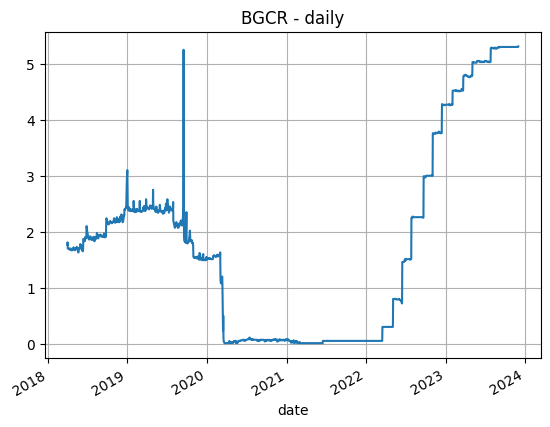

In [9]:
# this is our feature
# bgcr
x_bgcr = pd.read_excel(f"../data/bgcr.xlsx")
x_bgcr = x_bgcr.dropna(axis="columns")
# flip it so that first row
x_bgcr = x_bgcr.iloc[::-1]
x_bgcr.reset_index(inplace=True)
x_bgcr = x_bgcr.drop(columns=["index"])
x_bgcr.columns = ["date", "rate_type", "rate_bgcr", "vol_billion_usd"]
x_bgcr["date"] = pd.to_datetime(x_bgcr["date"])
x_bgcr.drop(columns=["rate_type", "vol_billion_usd"], inplace=True)
x_bgcr.set_index("date", inplace=True)
print(x_bgcr.head())
x_bgcr["rate_bgcr"].plot(grid=True, title="BGCR - daily")

## 3M Overnight Index Swap ##

In [10]:
# this is our feature
# 3MOIS
x_3mois = pd.read_csv(f"../data/USD3MOIS.csv")
x_3mois = x_3mois.dropna(axis="columns")
# flip it so that first row
x_3mois = x_3mois.iloc[::-1]
x_3mois.columns = ["date", "bid", "ask"]
x_3mois["date"] = pd.to_datetime(x_3mois["date"])
x_3mois["mid_3mois"] = 0.5 * (x_3mois["bid"] + x_3mois["ask"])
x_3mois.drop(columns=["bid", "ask"], inplace=True)
x_3mois.set_index("date", inplace=True)
x_3mois

,mid_3mois
date,
2018-01-02,1.4390
2018-01-03,1.4440
2018-01-04,1.4540
2018-01-05,1.4540
2018-01-08,1.4570
...,...
2023-11-17,5.3696
2023-11-20,5.3741
2023-11-21,5.3770


## 1M Overnight Index Swap ##

In [11]:
# this is our feature
# 1MOIS
x_1mois = pd.read_csv(f"../data/USD1MOIS.csv")
x_1mois = x_1mois.dropna(axis="columns")
# flip it so that first row
x_1mois = x_1mois.iloc[::-1]
x_1mois.columns = ["date", "bid", "ask", "mid_1mois"]
x_1mois.drop(columns=["bid", "ask"], inplace=True)
x_1mois["date"] = pd.to_datetime(x_1mois["date"])
x_1mois.set_index("date", inplace=True)
x_1mois

,mid_1mois
date,
2018-01-02,1.4150
2018-01-03,1.4160
2018-01-04,1.4200
2018-01-05,1.4160
2018-01-08,1.4200
...,...
2023-11-17,5.3443
2023-11-20,5.3461
2023-11-21,5.3460


In [12]:
plt.rcParams["font.size"] = "18"

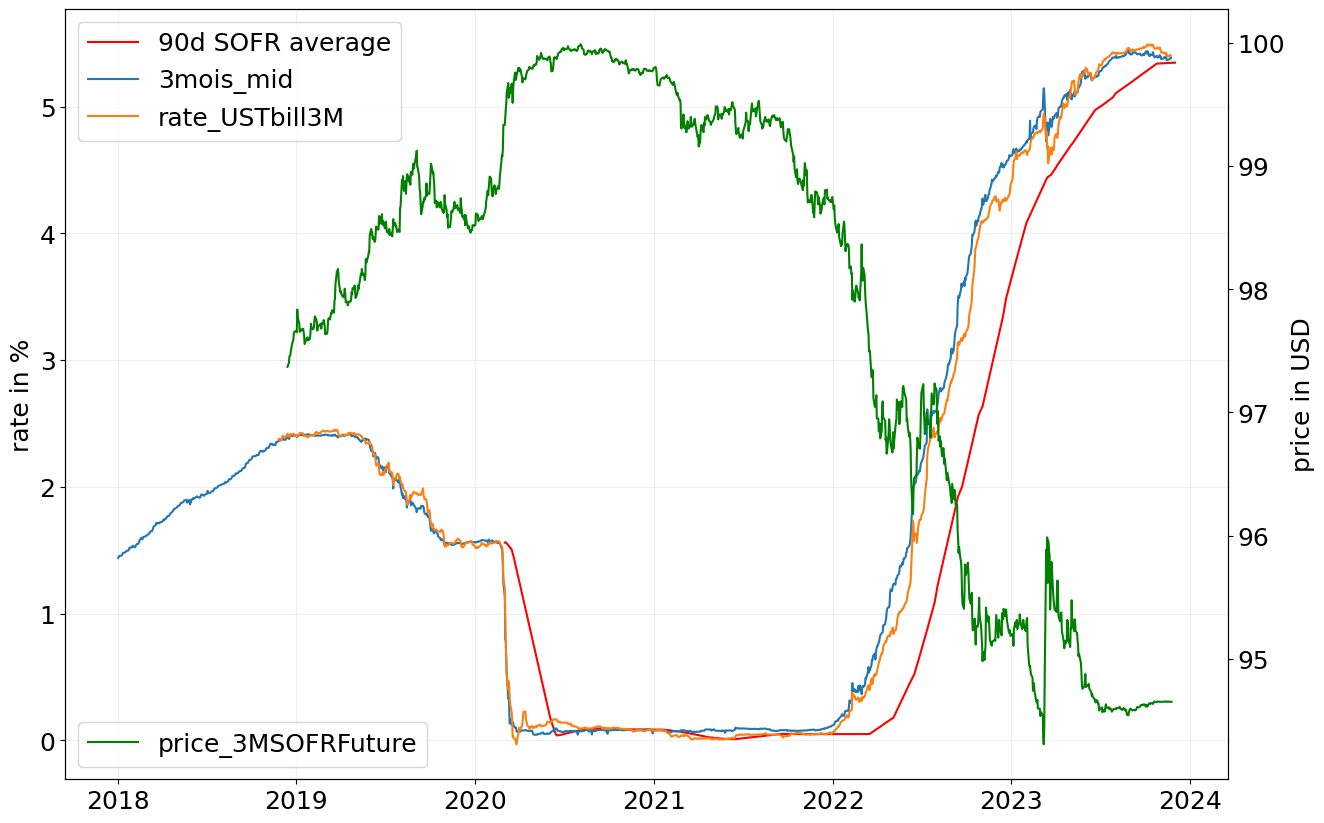

In [13]:
fig, ax1 = plt.subplots(figsize=(15, 10))
# ax1.plot(x_bgcr["rate_bgcr"], label="bgcr")


# ax1.plot(x_tgcr["rate_tgcr"], label="tgcr")


# ax1.plot(y_SOFRAI["30d"], label="30d")


ax1.plot(y_SOFRAI["90d"], label="90d SOFR average", color="red")


# ax1.plot(y_SOFRAI["180d"], label="180d")
# ax1.plot(x_1mois["mid_1mois"], label="1mois_mid")
ax1.plot(x_3mois["mid_3mois"], label="3mois_mid")


# ax1.plot(x_CME3MSOFR["rate_CME3MSOFR"], label="rate_CME3MSOFR")


ax1.plot(x_USTbill3M["rate_USTbill3M"], label="rate_USTbill3M")
ax1.set_ylabel("rate in %")
# ax1.plot(y_SOFRAI["90d"], label="90 day SOFR average")
ax2 = ax1.twinx()
ax2.plot(
    x_3MSOFRFuture["price_3MSOFRFuture"], label="price_3MSOFRFuture", color="green"
)
ax2.set_ylabel("price in USD")
ax2.legend(loc="lower left")
ax1.grid(alpha=0.2)


ax1.legend()
# fig.set_dpi(600)
fig.savefig("feature_target.jpeg", dpi=600)

# Data Concatenate to align time period #

In [14]:
# lets give it a shot ?
df = y_SOFRAI["90d"].copy()
# df.drop(columns=["30d", "180d", "idx"], inplace=True)
df

date
2020-03-02    1.56063
2020-03-03    1.56108
2020-03-04    1.56220
2020-03-05    1.55863
2020-03-06    1.55383
               ...   
2023-11-27    5.34572
2023-11-28    5.34595
2023-11-29    5.34618
2023-11-30    5.34618
2023-12-01    5.34643
Name: 90d, Length: 940, dtype: float64

In [15]:
to_concat = [x_3MSOFRFuture, x_3mois, x_1mois, x_USTbill3M]
for frames in to_concat:
    df = pd.merge(df, frames, on="date", how="left")
    print(df.isna().sum())
print(df.describe())

90d                   0
price_3MSOFRFuture    5
dtype: int64
90d                   0
price_3MSOFRFuture    5
mid_3mois             6
dtype: int64
90d                   0
price_3MSOFRFuture    5
mid_3mois             6
mid_1mois             6
dtype: int64
90d                   0
price_3MSOFRFuture    5
mid_3mois             6
mid_1mois             6
rate_USTbill3M        6
dtype: int64
              90d  price_3MSOFRFuture   mid_3mois   mid_1mois  rate_USTbill3M
count  940.000000          935.000000  934.000000  934.000000      934.000000
mean     1.578818           97.650711    1.876908    1.767966        1.808266
std      2.008006            2.062898    2.200005    2.146703        2.184893
min      0.010000           94.305000    0.043000   -0.009000       -0.031200
25%      0.049752           95.315000    0.078000    0.080000        0.057875
50%      0.147635           98.510000    0.201500    0.096000        0.180450
75%      3.504443           99.587500    4.543025    4.342750     

In [16]:
rows_with_na = df[df.isna().any(axis=1)]
rows_with_na

,90d,price_3MSOFRFuture,mid_3mois,mid_1mois,rate_USTbill3M
date,,,,,
2023-11-24,5.34507,94.65,NaN,NaN,NaN
2023-11-27,5.34572,NaN,NaN,NaN,NaN
2023-11-28,5.34595,NaN,NaN,NaN,NaN
2023-11-29,5.34618,NaN,NaN,NaN,NaN
2023-11-30,5.34618,NaN,NaN,NaN,NaN
2023-12-01,5.34643,NaN,NaN,NaN,NaN


In [17]:
df.dropna(inplace=True)
df.head(10)

,90d,price_3MSOFRFuture,mid_3mois,mid_1mois,rate_USTbill3M
date,,,,,
2020-03-02,1.56063,99.335,1.131,1.261,1.1963
2020-03-03,1.56108,99.405,0.793,1.003,0.9519
2020-03-04,1.56220,99.465,0.788,0.904,0.7524
2020-03-05,1.55863,99.515,0.621,0.803,0.6405
2020-03-06,1.55383,99.600,0.525,0.689,0.5126
2020-03-09,1.53866,99.675,0.327,0.472,0.4009
2020-03-10,1.53353,99.555,0.415,0.584,0.4655
2020-03-11,1.52874,99.565,0.231,0.320,0.4237
2020-03-12,1.52450,99.635,0.133,0.181,0.3336


## Advanced Feature Engineering ##

Interest rate data seems to have a regime, should we consider breaking up our training data to the appropriate regimes? Let's break it according to FOMC era instead


In [18]:
x_fomcrate = pd.read_excel("../data/fomc_rate.xlsx")
x_fomcrate.columns = ["date", "incr", "decr", "level"]
x_fomcrate[["lo", "hi"]] = x_fomcrate["level"].str.split("-", expand=True)
x_fomcrate["lo"] = pd.to_numeric(x_fomcrate["lo"])
x_fomcrate["hi"] = pd.to_numeric(x_fomcrate["hi"])
x_fomcrate["mean"] = 0.5 * (x_fomcrate["hi"] + x_fomcrate["lo"])
x_fomcrate.set_index("date", inplace=True)
x_fomcrate = x_fomcrate[::-1]
x_fomcrate

,incr,decr,level,lo,hi,mean
date,,,,,,
2018-03-22,25,0,1.50-1.75,1.50,1.75,1.625
2018-06-14,25,0,1.75-2.00,1.75,2.00,1.875
2018-09-27,25,0,2.00-2.25,2.00,2.25,2.125
2018-12-20,25,0,2.25-2.50,2.25,2.50,2.375
2019-08-01,0,25,2.00-2.25,2.00,2.25,2.125
2019-09-19,0,25,1.75-2.00,1.75,2.00,1.875
2019-10-31,0,25,1.50-1.75,1.50,1.75,1.625
2020-03-03,0,50,1.00-1.25,1.00,1.25,1.125
2020-03-16,0,100,0-0.25,0.00,0.25,0.125


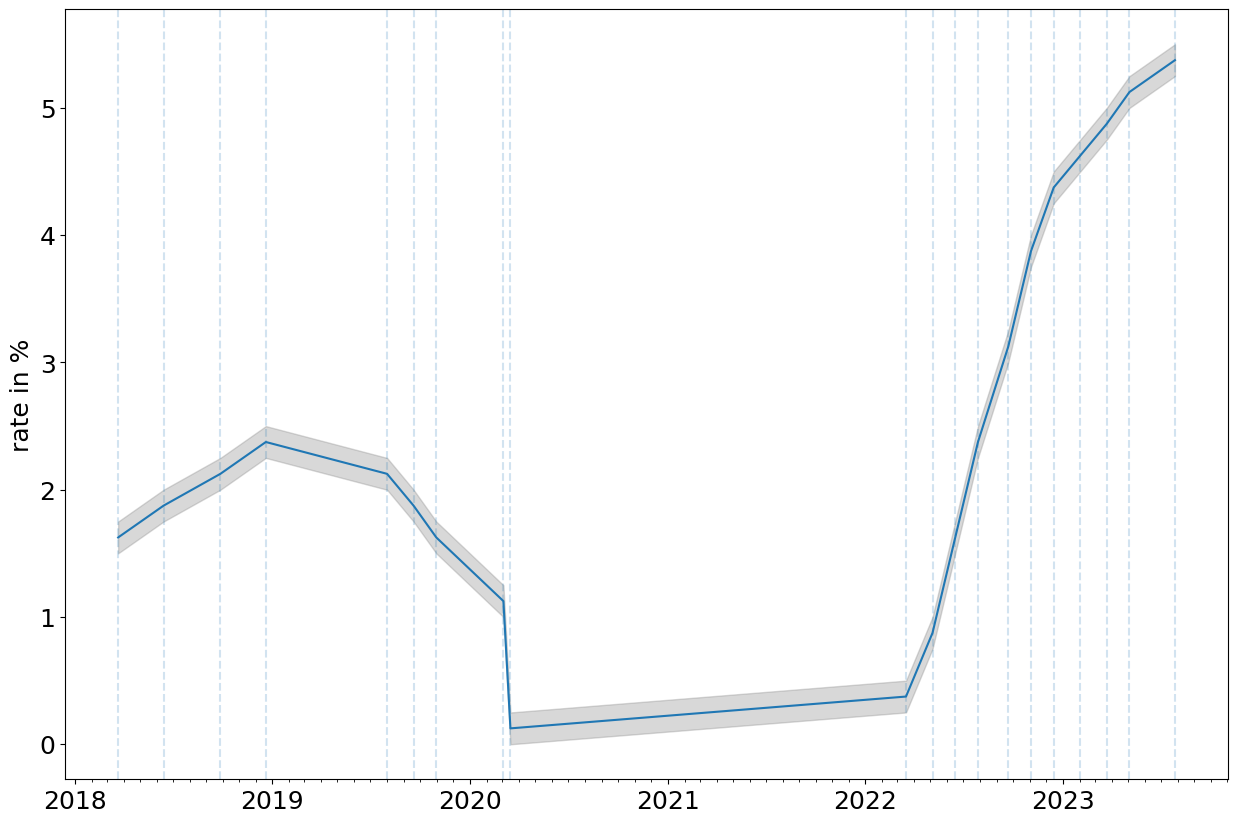

In [19]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(x_fomcrate.index, x_fomcrate["mean"], label="Mean Trend")
ax.fill_between(
    x_fomcrate.index,
    x_fomcrate["lo"],
    x_fomcrate["hi"],
    color="gray",
    alpha=0.3,
    label="Confidence Interval",
)
ax.xaxis.set_minor_locator(mdates.MonthLocator())
for rate_date in x_fomcrate.index:
    ax.axvline(rate_date, linestyle="dashed", alpha=0.2)
ax.set_ylabel("rate in %")
# fig.set_dpi(600)
fig.savefig("fomc.jpeg", dpi=600)

There are probably advanced methods for regime detection, but we can infer for the time being to atleast 3 parts
1. 2018 - 12/2019
2. 01/2020 - 12/2021
3. 01/2022 - onwards

In [20]:
df

,90d,price_3MSOFRFuture,mid_3mois,mid_1mois,rate_USTbill3M
date,,,,,
2020-03-02,1.56063,99.3350,1.1310,1.2610,1.1963
2020-03-03,1.56108,99.4050,0.7930,1.0030,0.9519
2020-03-04,1.56220,99.4650,0.7880,0.9040,0.7524
2020-03-05,1.55863,99.5150,0.6210,0.8030,0.6405
2020-03-06,1.55383,99.6000,0.5250,0.6890,0.5126
...,...,...,...,...,...
2023-11-16,5.34371,94.6500,5.3662,5.3423,5.3972
2023-11-17,5.34395,94.6525,5.3696,5.3443,5.3969
2023-11-20,5.34461,94.6500,5.3741,5.3461,5.4029


In [21]:
df_1 = df[df.index < pd.to_datetime("2019-12-31")]
df_1

,90d,price_3MSOFRFuture,mid_3mois,mid_1mois,rate_USTbill3M
date,,,,,


In [22]:
df_2 = df[
    (df.index >= pd.to_datetime("2020-01-01"))
    & (df.index <= pd.to_datetime("2021-12-31"))
]
df_2

,90d,price_3MSOFRFuture,mid_3mois,mid_1mois,rate_USTbill3M
date,,,,,
2020-03-02,1.56063,99.335,1.131,1.261,1.1963
2020-03-03,1.56108,99.405,0.793,1.003,0.9519
2020-03-04,1.56220,99.465,0.788,0.904,0.7524
2020-03-05,1.55863,99.515,0.621,0.803,0.6405
2020-03-06,1.55383,99.600,0.525,0.689,0.5126
...,...,...,...,...,...
2021-12-27,0.04911,98.710,0.108,0.081,0.0619
2021-12-28,0.04911,98.725,0.109,0.080,0.0503
2021-12-29,0.04911,98.710,0.112,0.081,0.0517


In [23]:
df_3 = df[(df.index >= pd.to_datetime("2022-01-01"))]
df_3

,90d,price_3MSOFRFuture,mid_3mois,mid_1mois,rate_USTbill3M
date,,,,,
2022-01-03,0.04911,98.6500,0.1220,0.0830,0.0695
2022-01-04,0.04911,98.6800,0.1240,0.0840,0.0688
2022-01-05,0.04911,98.5900,0.1390,0.0840,0.0751
2022-01-06,0.04911,98.5400,0.1470,0.0870,0.0825
2022-01-07,0.04911,98.5100,0.1480,0.0900,0.0861
...,...,...,...,...,...
2023-11-16,5.34371,94.6500,5.3662,5.3423,5.3972
2023-11-17,5.34395,94.6525,5.3696,5.3443,5.3969
2023-11-20,5.34461,94.6500,5.3741,5.3461,5.4029


## Mutual Information ##

In [24]:
y = df_3["90d"]
X = df_3.drop(columns=["90d", "mid_1mois"])

In [25]:
X

,price_3MSOFRFuture,mid_3mois,rate_USTbill3M
date,,,
2022-01-03,98.6500,0.1220,0.0695
2022-01-04,98.6800,0.1240,0.0688
2022-01-05,98.5900,0.1390,0.0751
2022-01-06,98.5400,0.1470,0.0825
2022-01-07,98.5100,0.1480,0.0861
...,...,...,...
2023-11-16,94.6500,5.3662,5.3972
2023-11-17,94.6525,5.3696,5.3969
2023-11-20,94.6500,5.3741,5.4029


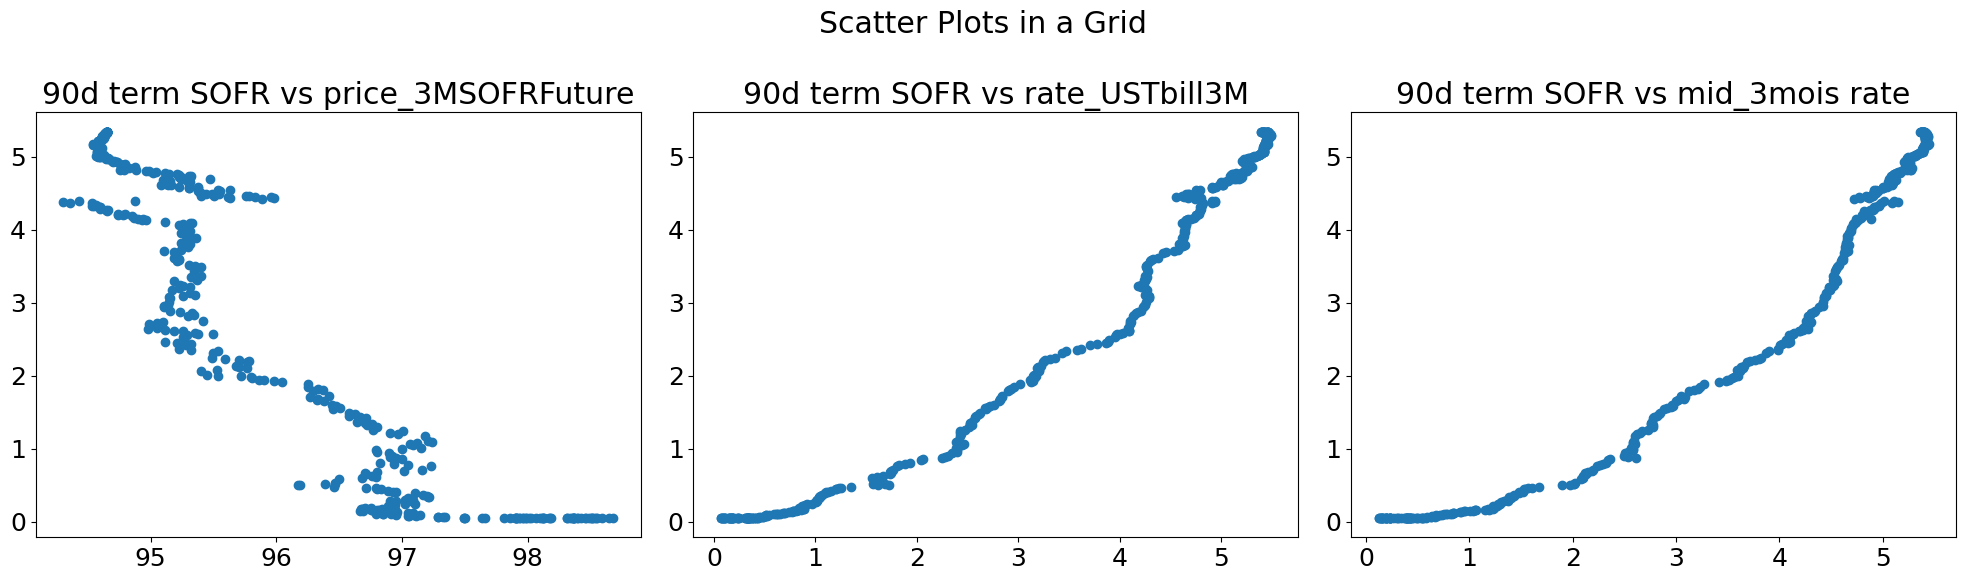

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
ax = ax.flatten()
ax[0].scatter(x=X["price_3MSOFRFuture"], y=y)
ax[0].set_title("90d term SOFR vs price_3MSOFRFuture")
ax[1].scatter(x=X["rate_USTbill3M"], y=y)
ax[1].set_title("90d term SOFR vs rate_USTbill3M")
# ax[2].scatter(x=X["rate_USTbill1M"], y=y)
# ax[2].set_title("90d term SOFR vs rate_USTbill1M")
# ax[1].scatter(x=X["rate_bgcr"], y=y)
# ax[1].set_title("90d term SOFR vs rate_bgcr")
ax[2].scatter(x=X["mid_3mois"], y=y)
ax[2].set_title("90d term SOFR vs mid_3mois rate")
# ax[3].scatter(x=X["mid_1mois"], y=y)
# ax[3].set_title("90d term SOFR vs mid_1mois rate")
fig.suptitle("Scatter Plots in a Grid")
fig.tight_layout()
fig.savefig("scatter.jpeg", dpi=600)

In [27]:
y.head()

date
2022-01-03    0.04911
2022-01-04    0.04911
2022-01-05    0.04911
2022-01-06    0.04911
2022-01-07    0.04911
Name: 90d, dtype: float64

In [28]:
X.head()

,price_3MSOFRFuture,mid_3mois,rate_USTbill3M
date,,,
2022-01-03,98.65,0.122,0.0695
2022-01-04,98.68,0.124,0.0688
2022-01-05,98.59,0.139,0.0751
2022-01-06,98.54,0.147,0.0825
2022-01-07,98.51,0.148,0.0861


In [29]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)

price_3MSOFRFuture    2.084058
mid_3mois             3.304892
rate_USTbill3M        3.341040
Name: MI Scores, dtype: float64


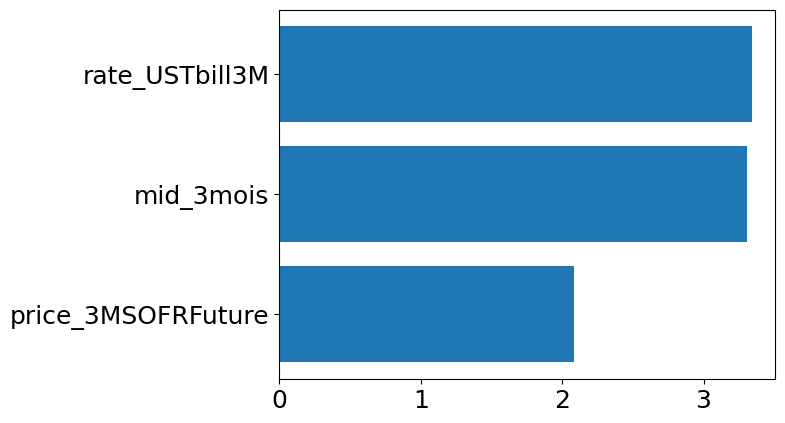

In [30]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    # plt.title("Mutual Information Scores")
    plt.savefig("mutual_info.jpeg", dpi=600)
    print(scores)


plot_mi_scores(mi_scores)

## Implement Linear Regression for Time Series Data ##

https://otexts.com/fpp2/regression.html

Instead of using lags, we will try use predictors for our target/ forecast variable.

In [31]:
pct_test_size = 0.3
my_test_size = round(len(X) * 0.3)
my_test_size

142

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=my_test_size, shuffle=False
)

model = LinearRegression()
model.fit(X_train, y_train)
y_fit = pd.Series(
    model.predict(X_train), index=y_train.index
)  # y from predicting using X_train
y_pred = pd.Series(
    model.predict(X_test), index=y_test.index
)  #  y from predicting using X_test
print(model.__dict__)

{'fit_intercept': True, 'copy_X': True, 'n_jobs': None, 'positive': False, 'feature_names_in_': array(['price_3MSOFRFuture', 'mid_3mois', 'rate_USTbill3M'], dtype=object), 'n_features_in_': 3, 'coef_': array([ 0.09787915, -1.54904327,  2.53342494]), 'rank_': 3, 'singular_': array([48.8672669 ,  6.40352967,  1.49780843]), 'intercept_': -9.825082331960266}


In [33]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)

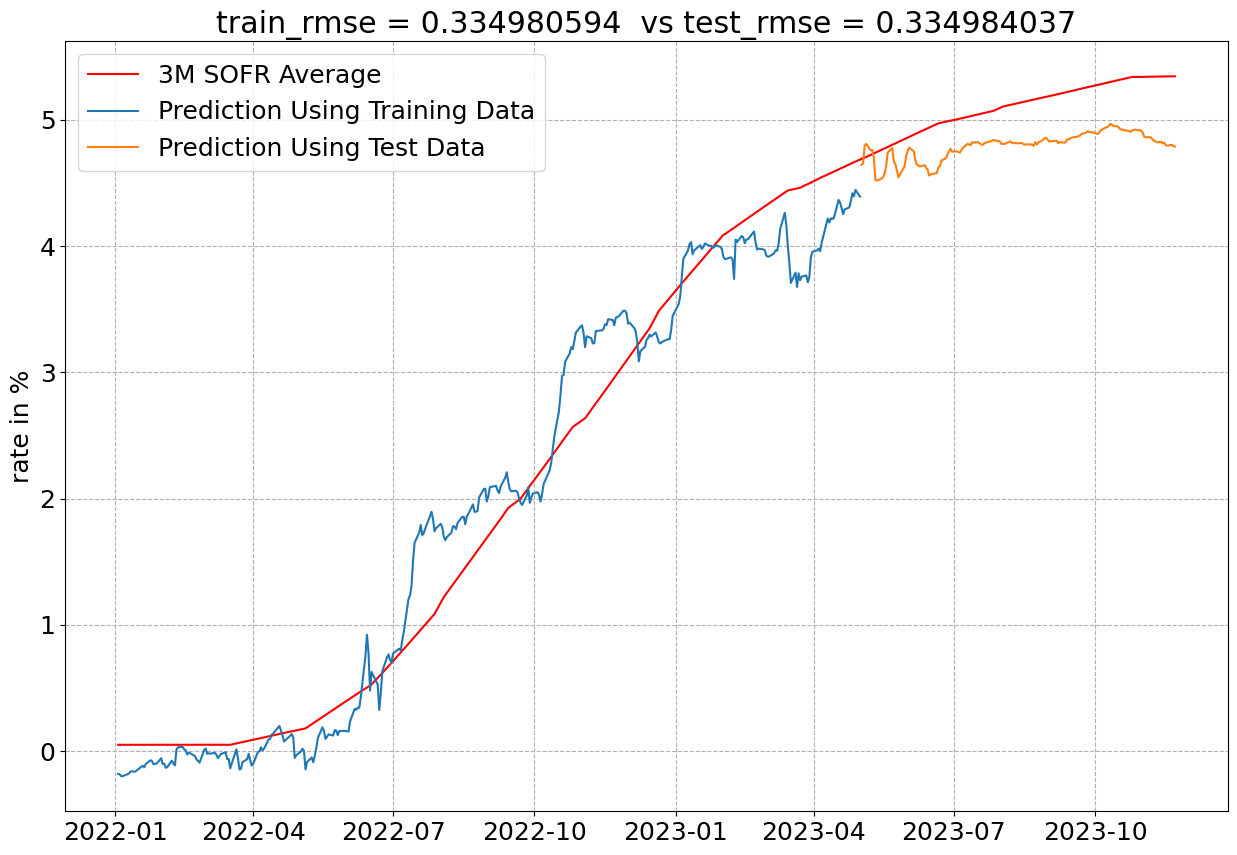

In [34]:
plt.figure(figsize=(15, 10))
plt.plot(y, label="3M SOFR Average", color="red")
plt.plot(y_fit, label="Prediction Using Training Data")
# plt.plot(y_cut, label="y_cut")
plt.plot(y_pred, label="Prediction Using Test Data")
# plt.plot(y_fit_roll, label="roll_train")
# plt.plot(y_pred_roll, label="roll_pred")
plt.ylabel("rate in %")
plt.title(f"train_rmse = {train_rmse:>8.9f}  vs test_rmse = {test_rmse:>8.9f}")
plt.grid(linestyle="dashed")
plt.legend()
plt.savefig("linear_only.jpeg", dpi=600)

In [35]:
# residuals from training
y_resid = pd.DataFrame(y_train - y_fit, columns=["resid"])
y_test_resid = pd.DataFrame(y_test - y_pred, columns=["resid"])

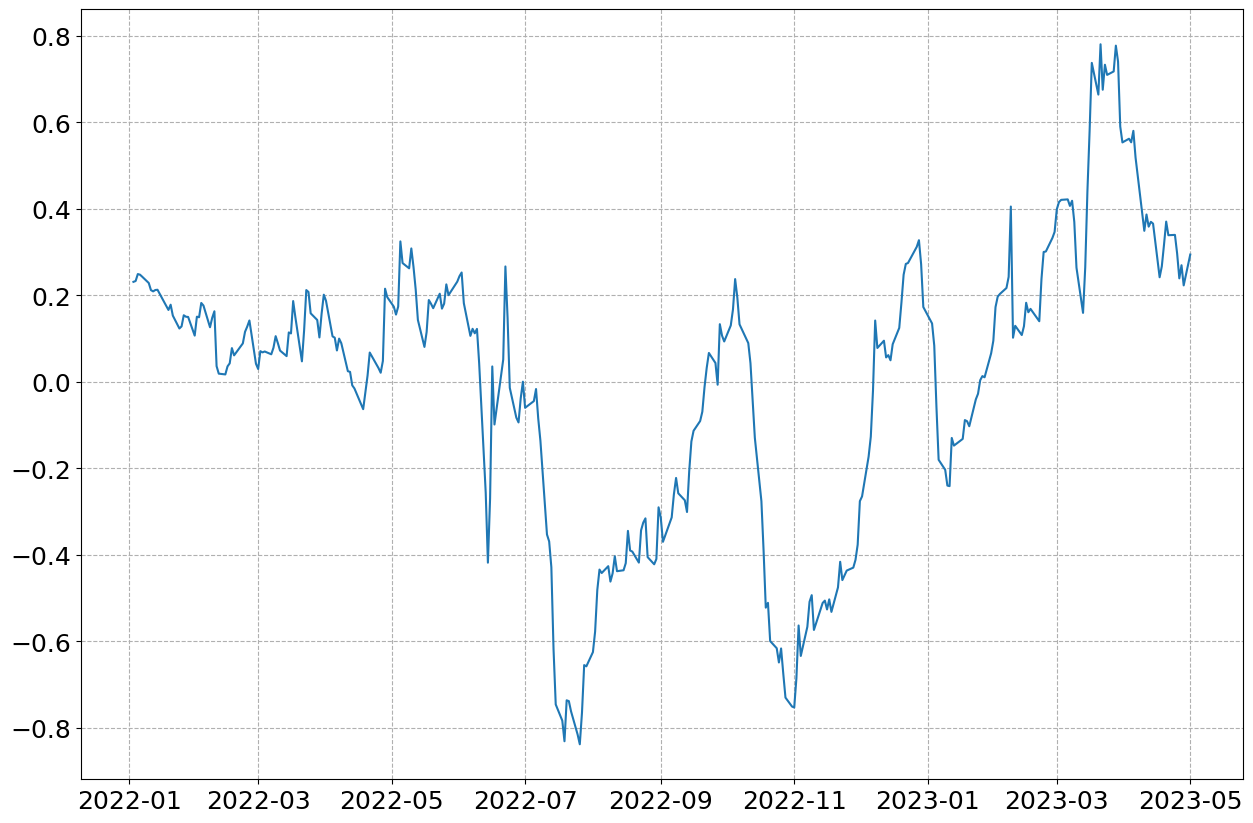

In [36]:
plt.figure(figsize=(15, 10))
plt.grid(linestyle="dashed")
plt.plot(y_resid)

In [37]:
plt.rcParams["font.size"] = "15"

In [38]:
# im sorry i used ur code !
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x) / 5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title="Time Series")
    x.rolling(21).mean().plot(ax=axes[0][0], c="k", lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f"Q-Stat: {np.max(q_p):>8.5f}\nADF: {adfuller(x)[1]:>11.5f}"
    axes[0][0].text(x=0.02, y=0.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f"Mean: {mean:>12.5f}\nSD: {np.sqrt(var):>16.5f}\nSkew: {skew:12.5f}\nKurtosis:{kurtosis:9.5f}"
    axes[0][1].text(x=0.02, y=0.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel("Lag")
    axes[1][1].set_xlabel("Lag")
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    fig.savefig("correlogram.jpeg", dpi=600)

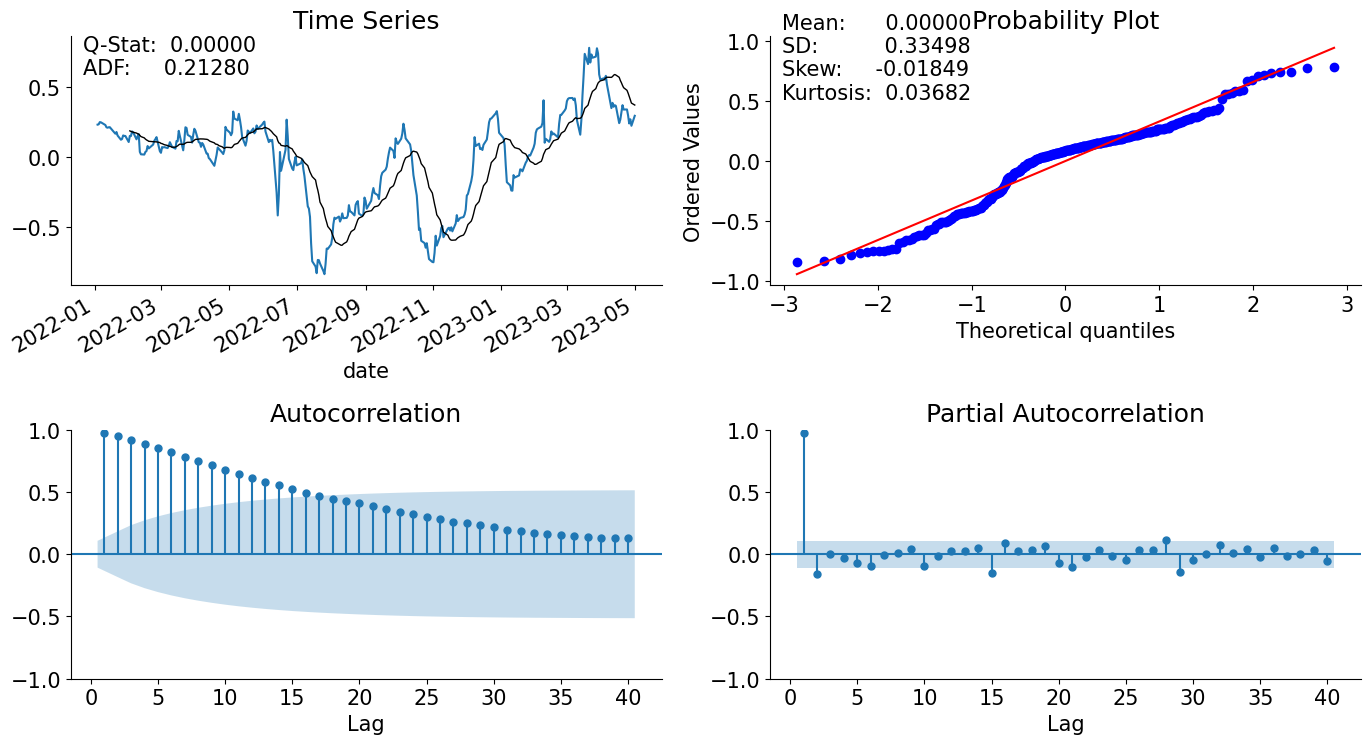

In [39]:
plot_correlogram(y_resid["resid"], 40)

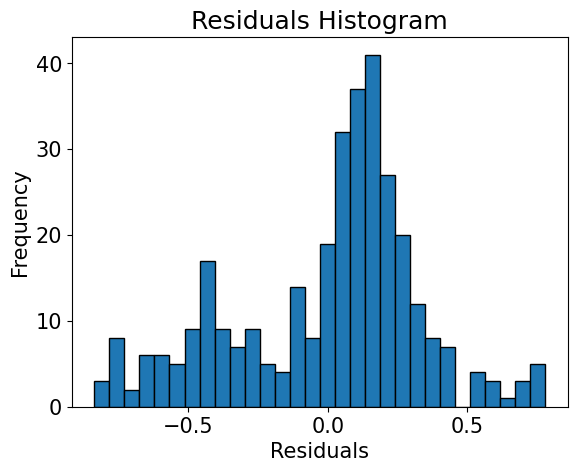

In [40]:
plt.hist(
    y_resid["resid"], bins=30, edgecolor="black"
)  # You can adjust the number of bins
plt.title("Residuals Histogram")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

Results are somewhat normal distribution, this should make our lives easier

In [41]:
# plot_correlogram(y_test_resid["resid"], 40)

## Hybrid Modelling with Gradient Boosting ##

One approach we can consider to improve our model is to use gradient boosting. Let's try XGBoost; THIS IS UNLOGICAL DO NOT IMPLEMENT

In [42]:
"""
lag = 5
def create_lags(df, n, col_to_lag):
    for i in range(1, n + 1):
        df[f"lag_{i}"] = df[col_to_lag].shift(i)
    return df


gb_train = pd.DataFrame(y_resid)
gb_train.columns = ["t"]
gb_train = create_lags(gb_train, lag, "t")
gb_train.dropna(inplace=True)
y_gb_train = gb_train["t"]
x_gb_train = gb_train.drop(columns=["t"])
gb_test = pd.DataFrame(y_test_resid)
gb_test.columns = ["t"]
gb_test = create_lags(gb_test, lag, "t")
gb_test.dropna(inplace=True)
y_gb_test = gb_test["t"]
x_gb_test = gb_test.drop(columns=["t"])
# Train XGBoost on the residuals (no outliers)
xgb_reg = xgb.XGBRegressor(n_estimators=1000)
xgb_reg.fit(x_gb_train, y_gb_train)
fit_boost_fit = pd.DataFrame(
    xgb_reg.predict(x_gb_train), index=x_gb_train.index, columns=["boost"]
)
fit_boost_pred = pd.DataFrame(
    xgb_reg.predict(x_gb_test), index=x_gb_test.index, columns=["boost"]
)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = pd.merge(y_train, fit_boost_fit, on="date", how="left")
y_fit_boosted.fillna(method="bfill", inplace=True)
y_pred_boosted = pd.merge(y_test, fit_boost_pred, on="date", how="left")
y_pred_boosted.fillna(method="bfill", inplace=True)
y_fit_boosted["sum"] = y_fit_boosted["boost"] + y_fit_boosted["90d"]
y_pred_boosted["sum"] = y_pred_boosted["boost"] + y_pred_boosted["90d"]
# RMSE
train_rmse = mean_squared_error(y_train, y_fit_boosted["sum"], squared=False)
test_rmse = mean_squared_error(y_test, y_pred_boosted["sum"], squared=False)
# PLOT
plt.figure()
plt.plot(y, label="actual y", color="red")
plt.plot(y_fit_boosted["sum"], label="y from predicting using X_train - BOOSTED")
# plt.plot(y_cut, label="y_cut")
plt.plot(y_pred_boosted["sum"], label=" y from predicting using X_test - BOOSTED")
plt.title(f"BOOSTEED : train_rmse = {train_rmse}  vs test_rmse = {test_rmse}")
plt.plot(x_CME3MSOFR["rate_CME3MSOFR"])
plt.grid(linestyle="dashed")
plt.legend()
"""

'\nlag = 5\ndef create_lags(df, n, col_to_lag):\n    for i in range(1, n + 1):\n        df[f"lag_{i}"] = df[col_to_lag].shift(i)\n    return df\n\n\ngb_train = pd.DataFrame(y_resid)\ngb_train.columns = ["t"]\ngb_train = create_lags(gb_train, lag, "t")\ngb_train.dropna(inplace=True)\ny_gb_train = gb_train["t"]\nx_gb_train = gb_train.drop(columns=["t"])\ngb_test = pd.DataFrame(y_test_resid)\ngb_test.columns = ["t"]\ngb_test = create_lags(gb_test, lag, "t")\ngb_test.dropna(inplace=True)\ny_gb_test = gb_test["t"]\nx_gb_test = gb_test.drop(columns=["t"])\n# Train XGBoost on the residuals (no outliers)\nxgb_reg = xgb.XGBRegressor(n_estimators=1000)\nxgb_reg.fit(x_gb_train, y_gb_train)\nfit_boost_fit = pd.DataFrame(\n    xgb_reg.predict(x_gb_train), index=x_gb_train.index, columns=["boost"]\n)\nfit_boost_pred = pd.DataFrame(\n    xgb_reg.predict(x_gb_test), index=x_gb_test.index, columns=["boost"]\n)\n\n# Add the predicted residuals onto the predicted trends\ny_fit_boosted = pd.merge(y_train,

## Alternative Boosing Method ? ##


1. Train and predict with first model
```
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)
```
2. Train and predict with second model on residuals
```
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)
```
3. Add to get overall predictions
```
y_pred = y_pred_1 + y_pred_2
```
Let's reimplement the linreg

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=my_test_size, shuffle=False
)

model = LinearRegression()
model.fit(X_train, y_train)
y_fit = pd.Series(
    model.predict(X_train), index=y_train.index
)  # y from predicting using X_train
y_pred = pd.Series(
    model.predict(X_test), index=y_test.index
)  #  y from predicting using X_test
print(model.__dict__)

{'fit_intercept': True, 'copy_X': True, 'n_jobs': None, 'positive': False, 'feature_names_in_': array(['price_3MSOFRFuture', 'mid_3mois', 'rate_USTbill3M'], dtype=object), 'n_features_in_': 3, 'coef_': array([ 0.09787915, -1.54904327,  2.53342494]), 'rank_': 3, 'singular_': array([48.8672669 ,  6.40352967,  1.49780843]), 'intercept_': -9.825082331960266}


In [44]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)

In [46]:
# residuals from training
y_resid = pd.DataFrame(y_train - y_fit, columns=["resid"])
y_test_resid = pd.DataFrame(y_test - y_pred, columns=["resid"])

In [47]:
# Train XGBoost on the residuals
xgb_reg = xgb.XGBRegressor(n_estimators=10000)
xgb_reg.fit(X_train, y_resid)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [48]:
# xgb score
xgb_reg.score(X_train, y_resid)

0.9999617036145027

In [49]:
# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb_reg.predict(X_train) + y_fit
y_pred_boosted = xgb_reg.predict(X_test) + y_pred

In [50]:
train_rmse = mean_squared_error(y_train, y_fit_boosted, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_boosted, squared=False)

In [51]:
plt.rcParams["font.size"] = "18"

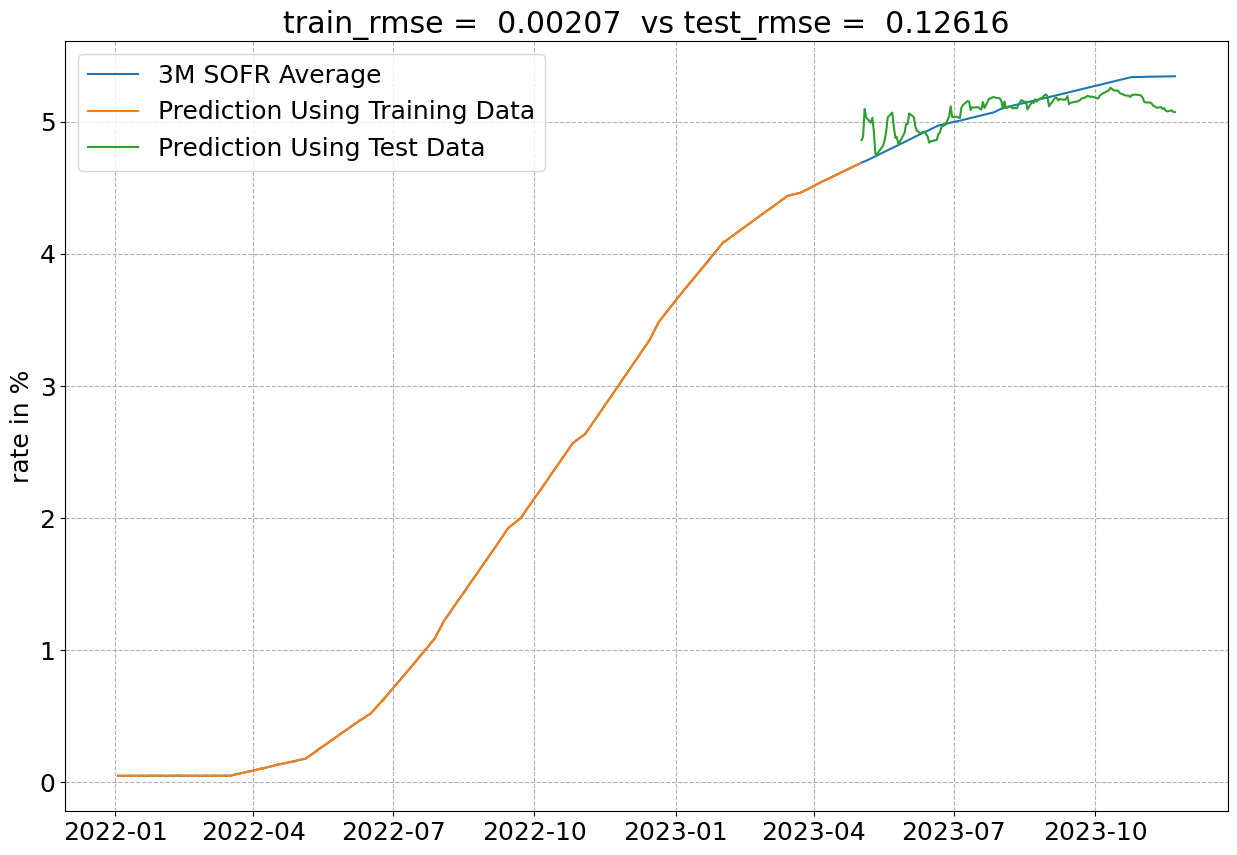

In [52]:
plt.figure(figsize=(15, 10))
plt.plot(y, label="3M SOFR Average")
plt.plot(y_fit_boosted, label="Prediction Using Training Data")
plt.plot(y_pred_boosted, label="Prediction Using Test Data")
plt.title(f"train_rmse = {train_rmse:>8.5f}  vs test_rmse = {test_rmse:>8.5f}")
plt.grid(linestyle="dashed")
plt.ylabel("rate in %")
plt.legend()
plt.savefig("boosted.jpeg", dpi=600)

##